### Analyse the accuracies

In [53]:
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np

import seaborn as sns
from IPython.display import display, Markdown

<h3> Dictionary for each dataset to its txt file path 

In [54]:
experiment_to_results_path = {
    "DBLP5_reten": r'stats/fast_gpa/20250723/2054.txt',
    "DBLP3_reten": r'stats/fast_gpa/20250723/2100.txt',
    "Reddit_reten": r'stats/fast_gpa/20250731/2135.txt',
    "Reddit_reten2": r'stats/fast_gpa/20250801/1105.txt',
    "SBM_reten": r'stats/fast_gpa/20250723/2113.txt',
    "DBLP5_NE_first": r'stats/fast_gpa/20250722/1508.txt',
    "DBLP3_NE_first": r'stats/fast_gpa/20250722/1521.txt',
    "Reddit_NE_first": r'stats/fast_gpa/20250722/1626.txt',
    "DBLP5_NE_last": r'stats/fast_gpa/20250723/1133.txt',
    "DBLP3_NE_last": r'stats/fast_gpa/20250723/1142.txt',
    "Reddit_NE_last": r'stats/fast_gpa/20250723/1152.txt',
    "DBLP5_NE_last0": r'stats/fast_gpa/20250723/1421.txt',
    "DBLP3_NE_last0": r'stats/fast_gpa/20250723/1424.txt',
    "Reddit_NE_last0": r'stats/fast_gpa/20250723/1427.txt',
    "DBLP5_NE_lastmid": r'stats/fast_gpa/20250723/1441.txt',
    "DBLP3_NE_lastmid": r'stats/fast_gpa/20250723/1455.txt',
    "Reddit_NE_lastmid": r'stats/fast_gpa/20250723/1500.txt',
    "UCI_NE_first": r'stats/fast_gpa/20250722/1711.txt',
    "UCI_NE_last": r'stats/fast_gpa/20250723/1216.txt',
    "DBLP5_MinCut_FedGCN": r'stats/fast_gpa/20250725/1826.txt',
    "DBLP3_MinCut_FedGCN": r'stats/fast_gpa/20250725/1837.txt',
    "Reddit_MinCut_FedGCN": r'stats/fast_gpa/20250725/1848.txt',
    # "DBLP5_Balance_FedGCN": r'stats/fast_gpa/20250726/2337.txt',
    "DBLP3_Balance_FedGCN": r'stats/fast_gpa/20250726/2319.txt',
    "Reddit_Balance_FedGCN": r'stats/fast_gpa/20250726/2313.txt',
    "DBLP5_Label_FedGCN": r'stats/fast_gpa/20250727/2226.txt',
    "DBLP3_Label_FedGCN": r'stats/fast_gpa/20250727/2225.txt',
    "Reddit_Label_FedGCN": r'stats/fast_gpa/20250727/2217.txt',
    "DBLP5_MinCut_NoNE": r'stats/fast_gpa/20250725/1812.txt',
    "DBLP5_Balance_NoNE": r'stats/fast_gpa/20250726/2349.txt',
    "DBLP3_Balance_NoNE": r'stats/fast_gpa/20250726/2347.txt',
    "Reddit_Balance_NoNE": r'stats/fast_gpa/20250726/2339.txt',
    "DBLP5_Label_NoNE": r'stats/fast_gpa/20250727/2304.txt',
    "DBLP3_Label_NoNE": r'stats/fast_gpa/20250727/2257.txt',
    "Reddit_Label_NoNE": r'stats/fast_gpa/20250727/2238.txt',
}
DATASET = "Reddit"
# compare = [f"{DATASET}_NE_last0", f"{DATASET}_MinCut_FedGCN", f"{DATASET}_Label_FedGCN", f"{DATASET}_MinCut_NoNE", f"{DATASET}_Balance_NoNE", f"{DATASET}_Label_NoNE"]
# label = ['Ours', 'MinCut_FedGCN', 'Label_FedGCN', 'MinCut_NoNE', 'Balance_NoNE', 'Label_NoNE']
compare = [f"{DATASET}_NE_last0", f"{DATASET}_MinCut_FedGCN", f"{DATASET}_Balance_NoNE"]
label = ['Ours', 'FedGCN', 'NoNE']

<h3> Function to parse each of the txt files that we ran to extract results

In [55]:
def parse_log_file(file_path):
    snapshot_to_local_accs = defaultdict(list)
    snapshot_to_global_accs = defaultdict(list)
    snapshot_aggregated_test_accs = defaultdict(list)
    snapshot_to_class_distribution = {}
    snapshot_to_best_round_metrics = {}
    snapshot_to_subgraph_num_and_distribution = {}

    snapshot_to_cut_edges = defaultdict(int)
    snapshot_to_edges = defaultdict(int)
    with open(file_path, 'r') as f:
        snapshot = None
        curr_local_list = []
        aggre_test_accs = []
        for line in f:
            snapshot_num_search = re.search(r"Snapshot (\d+)", line)
            if snapshot_num_search is not None:
                snapshot = int(snapshot_num_search.group(1))

            if '@Cloud> accuracy' in line:
                round_global_acc = re.search(r"accuracy\s*=\s*([+-]?\d*\.\d+)", line)
                if round_global_acc is not None:
                    global_acc = float(round_global_acc.group(1))
                    snapshot_to_global_accs[snapshot].append(global_acc)


            if '@Local> accuracy' in line:
                snapshot_match_list = re.search(r"\[(.*?)\]", line)
                if snapshot_match_list is not None:
                    curr_local_list.append([float(i) for i in snapshot_match_list.group(1).split(', ') if float(i) > 0])
            else:
                if curr_local_list != []:
                    snapshot_to_local_accs[snapshot].append(curr_local_list)
                    curr_local_list = []
                    
            if "Test Accuracy is" in line:
                snapshot_test_acc_match = re.search(r"Test Accuracy is (\d+\.\d+)", line)
                if snapshot_test_acc_match is not None:
                    aggre_test_accs.append(float(snapshot_test_acc_match.group(1)))
            else:
                if aggre_test_accs != []:
                    snapshot_aggregated_test_accs[snapshot].append(aggre_test_accs)
                    aggre_test_accs = []

            if "Subgraph" in line:
                subgraph_dict_match = re.search(r"Subgraph\s+(\d+):\s+(\{(?:\s*\d+\s*:\s*\d+\s*,?)+\})", line)
                if subgraph_dict_match is not None:
                    if snapshot not in snapshot_to_class_distribution:
                        snapshot_to_class_distribution[snapshot] = {}
                    snapshot_to_class_distribution[snapshot].update({int(subgraph_dict_match.group(1)):eval(subgraph_dict_match.group(2))})

            if "Best Round" in line:
                best_line_match = re.search(r"defaultdict\(None, ({.*})\)", line)
                if best_line_match is not None:
                    snapshot_to_best_round_metrics[snapshot] = eval(best_line_match[1])

            if "Client" in line and "training" in line:
                client_edges_line_match = re.search(r"Client (\d+) has (\d+) positive training edges", line)
                if client_edges_line_match is not None:
                    if snapshot not in snapshot_to_subgraph_num_and_distribution:
                        snapshot_to_subgraph_num_and_distribution[snapshot] = {}
                    snapshot_to_subgraph_num_and_distribution[snapshot].update({int(client_edges_line_match.group(1)):int(client_edges_line_match.group(2))})

            if "cut edges" in line:
                cut_edge_match = re.search(r"Total number of cut edges: (\d+)", line)
                if cut_edge_match is not None:
                    snapshot_to_cut_edges[snapshot] = int(cut_edge_match.group(1))

            if "A total" in line:
                edges_match = re.search(r"A total of (\d+) training edges", line)
                if edges_match is not None:
                    snapshot_to_edges[snapshot] = int(edges_match.group(1))

    return snapshot_to_local_accs, snapshot_to_global_accs, \
        snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
        snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
        snapshot_to_cut_edges, snapshot_to_edges

# snapshot_to_local_accs, snapshot_to_global_accs, \
# snapshot_aggregated_test_accs, snapshot_to_class_distribution, \
# snapshot_to_best_round_metrics, snapshot_to_subgraph_num_and_distribution,\
# snapshot_to_cut_edges, snapshot_to_edges\
#     = parse_log_file(experiment_to_results_path[DATASET])

## Record Time of Node Embedding Exchange

In [56]:
def extract_times_from_file(file_path):
    total_full_time = 0.0
    total_compute_time = 0.0
    total_comm_time = 0.0

    with open(file_path, 'r') as f:
        for line in f:
            if "Time taken for Full Node Embedding Exchange" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_full_time += float(match.group(1))
            elif "Time taken for Server to compute NE" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_compute_time += float(match.group(1))
            elif "Time taken for Communication" in line:
                match = re.search(r"([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)$", line.strip())
                if match:
                    total_comm_time += float(match.group(1))

    return total_full_time, total_compute_time, total_comm_time

def summarize_times_across_files(files, labels):
    data = []

    for file, label in zip(files, labels):
        full, compute, comm = extract_times_from_file(experiment_to_results_path[file])
        data.append({
            'Label': label,
            # 'File': os.path.basename(file),
            'Total Full Exchange Time (s)': round(full, 4),
            'Total Compute Time (s)': round(compute, 4),
            'Total Communication Time (s)': round(comm, 4)
        })

    df = pd.DataFrame(data)
    return df

def print_time_table(files, labels, save_path=None):
    df = summarize_times_across_files(files, labels)
    print(df)

    if save_path:
        df.to_csv(save_path, index=False)
        print(f"\nSaved timing summary to {save_path}")
    
    return df

def plot_time_comparison(df):
    labels = df['Label']
    x = range(len(labels))

    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar([i - width for i in x], df['Total Full Exchange Time (s)'], width=width, label='Full Exchange')
    plt.bar(x, df['Total Compute Time (s)'], width=width, label='Compute')
    plt.bar([i + width for i in x], df['Total Communication Time (s)'], width=width, label='Communication')

    plt.xticks(ticks=x, labels=labels, rotation=45, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel("Total Time (s)", fontsize=20)
    # plt.title("Total Time Breakdown per Method")
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.show()

    Label  Total Full Exchange Time (s)  Total Compute Time (s)  \
0    Ours                       56.0211                 33.4656   
1  FedGCN                        0.3194                  0.0041   
2    NoNE                        0.0000                  0.0000   

   Total Communication Time (s)  
0                       22.5554  
1                        0.3153  
2                        0.0000  


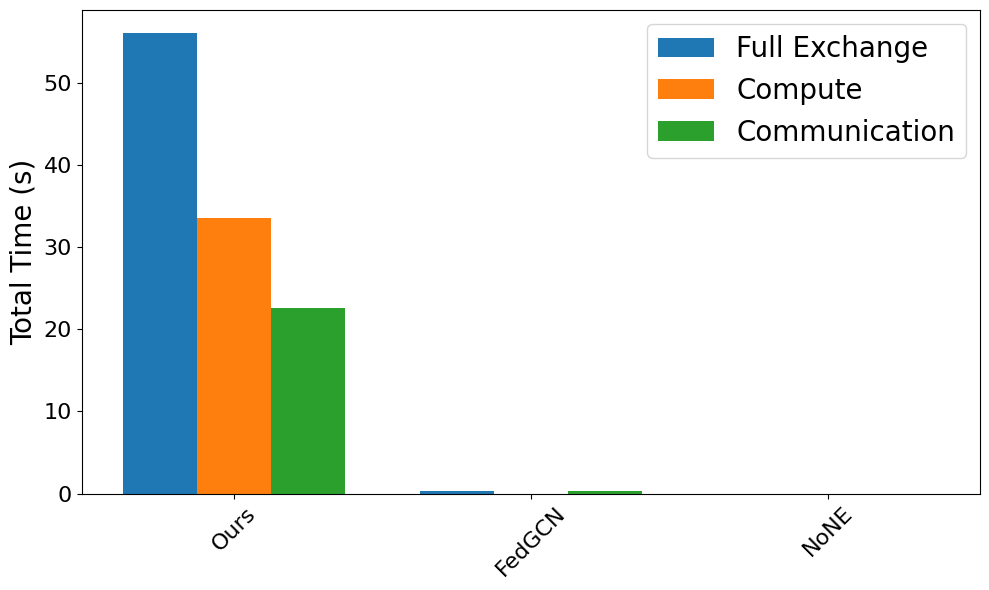

In [57]:
df = print_time_table(compare, label)
plot_time_comparison(df)

In [58]:
def parse_snapshot_times(filepath):
    snapshot_times = {}

    with open(filepath, 'r') as f:
        lines = f.readlines()

    current_snapshot = None
    for line in lines:
        line = line.strip()

        # Detect snapshot index
        snapshot_match = re.match(r"Snapshot (\d+)", line)
        if snapshot_match:
            current_snapshot = int(snapshot_match.group(1))
            snapshot_times[current_snapshot] = {
                "partition_time": 0.0,
                "node_state_time": 0.0
            }

        # Partition time
        if "Time taken to partition graph" in line and current_snapshot is not None:
            time_match = re.search(r"([0-9.]+)", line)
            if time_match:
                snapshot_times[current_snapshot]["partition_time"] = float(time_match.group(1))

        # Node state computation time
        if "Time taken for Full Node Embedding Exchange" in line and current_snapshot is not None:
            time_match = re.search(r"([0-9.]+)", line)
            if time_match:
                snapshot_times[current_snapshot]["node_state_time"] = float(time_match.group(1))

    return snapshot_times

def parse_outside_snapshot_times(filepath):
    snapshot_times = {}

    with open(filepath, 'r') as f:
        lines = f.readlines()

    for line in lines:
        line = line.strip()

        # Match: [SNAPSHOT 1/8] Time taken for Graph Partitioning: 0.17055415298091248
        snapshot_match = re.match(r"\[SNAPSHOT\s+(\d+)/\d+\]\s+Time taken for Graph Partitioning:\s+([0-9.eE+-]+)", line)
        if snapshot_match:
            snapshot_idx = int(snapshot_match.group(1))
            partition_time = float(snapshot_match.group(2))

            snapshot_times[snapshot_idx] = {
                "partition_time": partition_time,
                "node_state_time": 0.0  # optional placeholder
            }

    return snapshot_times

def plot_snapshot_times(snapshot_times, dataset=""):
    snapshots = sorted(snapshot_times.keys())
    partition_times = [snapshot_times[s]['partition_time'] for s in snapshots]
    node_state_times = [snapshot_times[s]['node_state_time'] for s in snapshots]
    total_times = [p + n for p, n in zip(partition_times, node_state_times)]

    x = np.arange(len(snapshots))
    width = 0.25

    plt.figure(figsize=(8, 5))
    bars1 = plt.bar(x - width, partition_times, width, label='Partition Time', color='#2ca02c')
    bars2 = plt.bar(x, node_state_times, width, label='Node State Time', color='#1f77b4')
    bars3 = plt.bar(x + width, total_times, width, label='Total Time', color='#ff7f0e')

    # Add total time as text above the bars
    for i, total in enumerate(total_times):
        plt.text(x[i] + width, total + 0.02, f"{total:.2f}s", ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xlabel('Snapshot')
    plt.ylabel('Time (s)')
    plt.ylim((0,0.5))
    plt.title(f'{dataset} - Time per Snapshot: Partitioning, Node State, and Total')
    plt.xticks(x, [f"{s}" for s in snapshots])
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# snapshot_times = parse_snapshot_times(experiment_to_results_path["Reddit_NE_last0"])
# plot_snapshot_times(snapshot_times, dataset="DBLP5 Our NE")

# # Extract all partition times
# partition_times = [info["partition_time"] for info in snapshot_times.values()]

# # Compute average
# if partition_times:
#     avg_partition_time = sum(partition_times) / len(partition_times)
#     print(f"Average partition time: {avg_partition_time:.6f} seconds")
# else:
#     print("No partition times found.")


In [59]:
# data = ""
# snapshot_times = parse_outside_snapshot_times(experiment_to_results_path[data])
# # Extract all partition times
# partition_times = [info["partition_time"] for info in snapshot_times.values()]

# # Compute average
# if partition_times:
#     avg_partition_time = sum(partition_times) / len(partition_times)
#     print(f"Average partition time: {avg_partition_time:.6f} seconds")
# else:
#     print("No partition times found.")

## Recording Accuracies over Snapshots

### Take a look at Local Clients' Accuracies over Snapshots

In [60]:
def parse_snapshot_local_accuracies(filepath):
    """
    Parses local accuracy values from the log file.
    Returns:
        snapshot_to_client_accuracies: dict mapping snapshot -> client_id -> list of accuracies
            {
                0: { 0: [...], 1: [...], ..., n: [...] },
                1: { ... }
            }
    """
    snapshot_to_client_accuracies = defaultdict(lambda: defaultdict(list))
    current_snapshot = None

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()

            # Detect snapshot
            snapshot_match = re.match(r"Snapshot (\d+)", line)
            if snapshot_match:
                current_snapshot = int(snapshot_match.group(1))

            # Detect local accuracies
            if "@Local> accuracy" in line and current_snapshot is not None:
                match = re.search(r"accuracy\s*=\s*\[([^\]]+)\]", line)
                if match:
                    str_values = match.group(1).split(',')
                    float_values = [float(x.strip()) for x in str_values]
                    for client_id, acc in enumerate(float_values):
                        snapshot_to_client_accuracies[current_snapshot][client_id].append(acc)

    return snapshot_to_client_accuracies

def plot_snapshot_client_accuracies(snapshot_to_client_accuracies):
    num_snapshots = len(snapshot_to_client_accuracies)
    num_cols = 2
    num_rows = (num_snapshots + 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows), squeeze=False)
    fig.suptitle("Client Accuracy per Epoch (Grouped by Snapshot)", fontsize=16, y=0.99)

    all_handles = []
    all_labels = []
    collected_labels = set()

    for idx, (snapshot, client_to_accs) in enumerate(sorted(snapshot_to_client_accuracies.items())):
        ax = axes[idx // num_cols][idx % num_cols]

        for client_id, acc_list in sorted(client_to_accs.items()):
            line, = ax.plot(acc_list, label=f'Client {client_id}', linewidth=1)
            
            # Collect handles only once per client (avoiding duplicates)
            if f'Client {client_id}' not in collected_labels:
                all_handles.append(line)
                all_labels.append(f'Client {client_id}')
                collected_labels.add(f'Client {client_id}')

        ax.set_title(f"Snapshot {snapshot}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0, 1)
        ax.grid(True)

    # Adjust layout and add global legend outside plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    fig.legend(all_handles, all_labels, loc='center left', bbox_to_anchor=(0.92, 0.5), title="Clients")

    plt.show()

def plot_combined_accuracy_and_edges(snapshot_to_client_accuracies, snapshot_to_subgraph_num_and_distribution):
    snapshots = sorted(snapshot_to_client_accuracies.keys())
    num_snapshots = len(snapshots)
    
    # Assume 10 clients (0-9); get consistent color mapping using a colormap
    client_ids = list(range(10))
    cmap = plt.colormaps.get_cmap('tab10')  # use tab10 for categorical color palette
    client_colors = {client: cmap(client) for client in client_ids}
    
    fig, axes = plt.subplots(num_snapshots, 2, figsize=(14, 4 * num_snapshots))
    fig.suptitle("Client Accuracy and Edge Count per Snapshot", fontsize=18, y=0.99)

    if num_snapshots == 1:
        axes = np.array([axes])  # ensure 2D array even for one snapshot

    for i, snapshot in enumerate(snapshots):
        # --- Bar chart (left) ---
        edge_ax = axes[i, 0]
        edge_data = snapshot_to_subgraph_num_and_distribution.get(snapshot, {})
        clients = sorted(edge_data.keys())
        edge_counts = [edge_data[client] for client in clients]

        bars = edge_ax.bar(
            clients, edge_counts,
            color=[client_colors[client] for client in clients]
        )
        edge_ax.set_title(f"Snapshot {snapshot}: Edge Distribution")
        edge_ax.set_xlabel("Client ID")
        edge_ax.set_ylabel("#Edges")
        edge_ax.grid(True, axis='y')

        # --- Line plot (right) ---
        acc_ax = axes[i, 1]
        client_to_accs = snapshot_to_client_accuracies[snapshot]
        for client_id, acc_list in sorted(client_to_accs.items()):
            acc_ax.plot(acc_list, label=f"Client {client_id}", linewidth=1.5, color=client_colors[client_id])

        acc_ax.set_title(f"Snapshot {snapshot}: Local Accuracy over Epochs")
        acc_ax.set_xlabel("Epoch")
        acc_ax.set_ylabel("Accuracy")
        acc_ax.set_ylim(0, 1)
        acc_ax.grid(True)

        # --- Per-row legend (only for the line plot) ---
        # handles, labels = acc_ax.get_legend_handles_labels()
        # acc_ax.legend(handles, labels, loc='upper right', fontsize=9)

    # Place one legend outside all line plots (shared)
    handles, labels = axes[0, 1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 0.98), fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# local_accuracies = parse_snapshot_local_accuracies(experiment_to_results_path[DATASET])

In [61]:
# plot_combined_accuracy_and_edges(local_accuracies, snapshot_to_subgraph_num_and_distribution)
# plot_snapshot_client_accuracies(local_accuracies)

### Take a look at the Global Accuracy over Snapshots

In [62]:
def parse_snapshot_file(file_path):
    snapshot_to_global_accs = defaultdict(list)
    snapshot = None

    with open(experiment_to_results_path[file_path], 'r') as f:
        for line in f:
            snapshot_num_search = re.search(r"Snapshot (\d+)", line)
            if snapshot_num_search is not None:
                snapshot = int(snapshot_num_search.group(1))

            if '@Cloud> accuracy' in line:
                round_global_acc = re.search(r"accuracy\s*=\s*([+-]?\d*\.\d+)", line)
                if round_global_acc is not None and snapshot is not None:
                    global_acc = float(round_global_acc.group(1))
                    snapshot_to_global_accs[snapshot].append((global_acc,))
    
    return snapshot_to_global_accs

def plot_global_accuracy(snapshot_data, label=None, color=None):
    all_values = []
    snapshot_start_indices = []
    index = 0

    for snapshot_id in sorted(snapshot_data.keys()):
        rounds = snapshot_data[snapshot_id]
        snapshot_start_indices.append(index)
        for item in rounds:
            all_values.append(item[0])
            index += 1

    plt.plot(range(1, len(all_values)+1), all_values, marker='o', label=label, color=color)

    for i, snapshot_start in enumerate(snapshot_start_indices):
        if snapshot_start > 0:
            plt.axvline(snapshot_start + 1, color='gray', linestyle='--', alpha=0.3)

def plot_multiple_global_accuracies(file_paths, labels):
    colors = plt.cm.tab10.colors

    plt.figure(figsize=(12, 6))

    for i, (file_path, label) in enumerate(zip(file_paths, labels)):
        snapshot_data = parse_snapshot_file(file_path)
        plot_global_accuracy(snapshot_data, label=label, color=colors[i % len(colors)])

    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [63]:
# modified_dict = {}
# for snapshot in snapshot_to_global_accs:
#     modified_dict[snapshot] = [[[i] for i in snapshot_to_global_accs[snapshot]]]
    
# plot_global_accuracy(modified_dict)

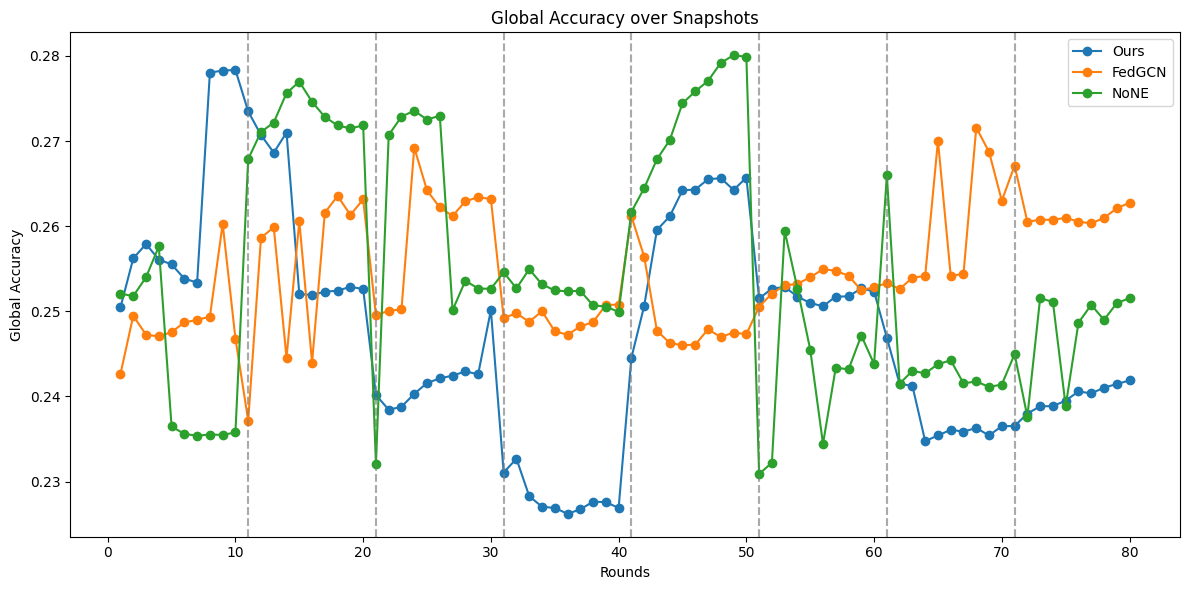

In [64]:
plot_multiple_global_accuracies(compare, label)

### Compare Multiple Approaches Global Accuracies

In [65]:
''' Only show data, without saying the best accuracies per txt file '''
def plot_multiple_global_accuracies(datas, labels):
    plt.figure(figsize=(12, 6))

    for data, label in zip(datas, labels):        
        # Flatten global accuracies across all snapshots
        all_values = []
        snapshot_start_indices = []
        index = 0

        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # Assuming item[0] is the global accuracy
                index += 1

        # Plot the global accuracy curve for this file
        plt.plot(range(1, len(all_values)+1), all_values, marker='o', label=label)

    # Plot decorations
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots (Multiple Strategies)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

''' Show the best accuracy per txt file, but show it on the data point '''
def plot_multiple_global_accuracies(datas, labels):
    plt.figure(figsize=(12, 6))

    for data, label in zip(datas, labels):
        # Flatten global accuracies across all snapshots
        all_values = []
        snapshot_start_indices = []
        index = 0

        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # Assuming item[0] is the global accuracy
                index += 1

        # X values for plotting
        x_values = list(range(1, len(all_values)+1))

        # Plot the line
        plt.plot(x_values, all_values, marker='o', label=label)

        # Find and highlight max accuracy
        max_acc = max(all_values)
        max_idx = all_values.index(max_acc)
        plt.scatter(x_values[max_idx], max_acc, color='red', zorder=5)
        plt.text(x_values[max_idx], max_acc + 0.005, f"{max_acc:.4f}", color='red', fontsize=9, ha='center')

    # Final plot settings
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots (Multiple Runs)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [66]:
''' Show the best accuracies on the legeng for clarity '''
def plot_multiple_global_accuracies(datas, labels):
    plt.figure(figsize=(12, 6))

    for data, label in zip(datas, labels):       
        # Flatten global accuracies across all snapshots
        all_values = []
        snapshot_start_indices = []
        index = 0

        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # Assuming item[0] is the global accuracy
                index += 1

        x_values = list(range(1, len(all_values)+1))

        # Find and highlight max accuracy
        max_acc = max(all_values)
        max_idx = all_values.index(max_acc)

        # Include best accuracy in the label
        label_with_acc = f"{label} (Best: {max_acc:.4f})"

        # Plot line
        plt.plot(x_values, all_values, marker='o', label=label_with_acc)

        # Optionally highlight the best point
        plt.scatter(x_values[max_idx], max_acc, color='red', zorder=5)

    # Plot formatting
    plt.xlabel("Rounds")
    plt.ylabel("Global Accuracy")
    plt.title("Global Accuracy over Snapshots (Multiple Runs)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [67]:
''' Show snapshots on the xlabel instead of rounds '''
def plot_multiple_global_accuracies_with_snapshot_xticks(datas, labels, dataset):
    plt.figure(figsize=(10, 6))

    for data, label in zip(datas, labels):
        all_values = []
        snapshot_start_indices = []
        index = 0

        # sorted(data.keys())
        # [0,1,2,3,4,5,6]
        for snapshot_id in sorted(data.keys()):
            rounds = data[snapshot_id][0]
            snapshot_start_indices.append(index)
            for item in rounds:
                all_values.append(item[0])  # global accuracy
                index += 1

        x_values = list(range(1, len(all_values)+1))

        # Highlight best point
        max_acc = max(all_values)
        max_idx = all_values.index(max_acc)
        label_with_acc = f"{label} (Best: {max_acc:.4f})"

        plt.plot(x_values, all_values, label=label_with_acc, linewidth=3)
        plt.scatter(x_values[max_idx], max_acc, color='yellow', zorder=5)

    # Set x-ticks at snapshot boundaries
    xtick_positions = [i+1 for i in snapshot_start_indices]  # +1 because x_values start from 1
    xtick_labels = [f"Snapshot {i}" for i in range(len(xtick_positions))]
    plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Snapshot", fontsize=17)
    plt.ylabel("Global Accuracy", fontsize=17)
    plt.title(f"{dataset}", fontsize=20)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

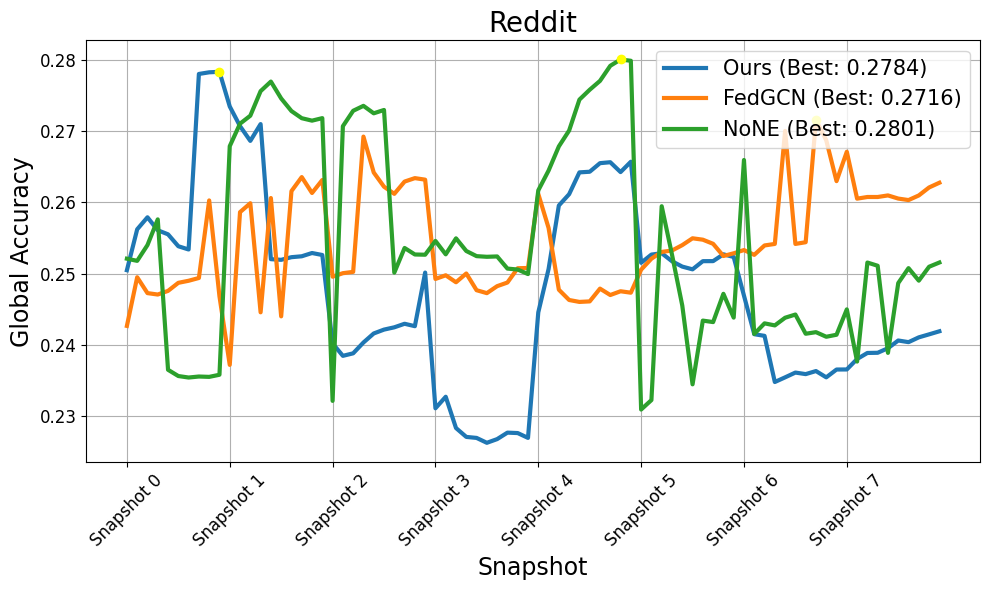

In [68]:
data_list = []
for strat in compare:
    _, snapshot_to_global_accs, _, _, _, _, _, _ = parse_log_file(experiment_to_results_path[strat])
    modified_dict = {}
    for snapshot in snapshot_to_global_accs:
        modified_dict[snapshot] = [[[i] for i in snapshot_to_global_accs[snapshot]]]
    data_list.append(modified_dict)

plot_multiple_global_accuracies_with_snapshot_xticks(data_list, label, dataset=DATASET)

### Compute the Average Global Accuracy

We obtain the best accuracy of each snapshot, and take an average of them.

In [69]:
import re
import os
from collections import defaultdict

def extract_best_f1_from_file(file_path):
    best_f1_scores = []

    with open(file_path, 'r') as f:
        for line in f:
            if "Snapshot Ends." in line and "Best Metrics" in line:
                # Use regex to extract best_f1
                match = re.search(r"'best_f1': ([0-9.]+)", line)
                if match:
                    best_f1 = float(match.group(1))
                    best_f1_scores.append(best_f1)

    return best_f1_scores

def summarize_best_f1_across_files(files):
    data = []

    for file in files:
        best_f1s = extract_best_f1_from_file(experiment_to_results_path[file])
        avg_f1 = sum(best_f1s) / len(best_f1s) if best_f1s else 0.0
        data.append({
            'Label': file,
            'File': os.path.basename(file),
            'Snapshots': len(best_f1s),
            'Avg Best F1': round(avg_f1, 4)
        })

    df = pd.DataFrame(data)
    return df

def print_best_f1_table(files, save_path=None):
    df = summarize_best_f1_across_files(files)
    print(df)

    if save_path:
        df.to_csv(save_path, index=False)
        print(f"\nSaved table to {save_path}")

In [70]:
print_best_f1_table(compare)

                  Label                  File  Snapshots  Avg Best F1
0       Reddit_NE_last0       Reddit_NE_last0          8       0.2552
1  Reddit_MinCut_FedGCN  Reddit_MinCut_FedGCN          8       0.2623
2   Reddit_Balance_NoNE   Reddit_Balance_NoNE          8       0.2650


## Record Forgetting

In [88]:
# List of txt files
txt_files = [
    ("DBLP5", "DBLP5_reten"),
    ("DBLP3", "DBLP3_reten"),
    ("Reddit", "Reddit_reten"),
    ("Reddit2", "Reddit_reten2"),
]

def extract_forgetting(txt_files):

    # Modified regex pattern to capture negative numbers and scientific notation
    reten_pattern = re.compile(r"Retention Rate =\s*\{'f1':\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\}")
    snapshot_pattern = re.compile(r"Snapshot\s+(\d+)")

    reten_data = []

    for dataset, filename in txt_files:
        filepath = experiment_to_results_path[filename]
        retention_rates = []
        snapshot_x_positions = []
        current_line_idx = 0
        
        with open(filepath, 'r') as file:
            for line in file:
                # Extract F1 score
                f1_match = reten_pattern.search(line)
                if f1_match:
                    retention_rates.append(float(f1_match.group(1)))
                    current_line_idx += 1
                
                # Record where snapshots start
                if snapshot_pattern.search(line):
                    snapshot_x_positions.append(current_line_idx)

        reten_data.append((dataset, retention_rates, snapshot_x_positions))

    return reten_data

def plot_reten(reten_data):
    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(22, 5), sharey=False, sharex=False)
    axs = axs.flatten()

    for idx, (dataset, rates, snapshot_positions) in enumerate(reten_data):
        bounded_rates = np.clip(rates, 0.0, 1.0)
        axs[idx].plot(bounded_rates, linewidth=3)
        axs[idx].set_title(f"{dataset}", fontsize=19)
        axs[idx].set_xlabel("Snapshot", fontsize=17)
        axs[idx].set_ylabel("F1 Score", fontsize=17)
        axs[idx].set_ylim(0, 1.1)
        axs[idx].grid(True)

        # Set x-ticks at snapshot start positions
        snapshot_labels = [f"{i}" for i in range(len(snapshot_positions))]
        axs[idx].set_xticks(snapshot_positions)
        axs[idx].set_xticklabels(snapshot_labels, fontsize=12) #rotation=45, 

    for ax in axs:
        ax.tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.suptitle("Performance Retention Rate Across Snapshots", fontsize=20, y=1.06)
    plt.show()

reten_data = extract_forgetting(txt_files)

In [89]:
# Compute statistics for each dataset
results = []
for dataset, forgetting, _ in reten_data:
    mean = np.mean(forgetting) * 100
    std = np.std(forgetting, ddof=1) * 100  # Sample standard deviation
    results.append({
        'Dataset': dataset,
        'Average Forgetting': mean,
        'Uncertainty (±)': std,
        'Min': np.min(forgetting),
        'Max': np.max(forgetting)
    })

# Print as a table
print(f"{'Dataset':<10} | {'Avg Forgetting':>12} | {'± Uncertainty':>12} | {'Min':>6} | {'Max':>6}")
print("-" * 60)
for r in results:
    print(f"{r['Dataset']:<10} | {r['Average Forgetting']:>12.3f} | {r['Uncertainty (±)']:>12.3f} | {r['Min']:>6.3f} | {r['Max']:>6.3f}")

Dataset    | Avg Forgetting | ± Uncertainty |    Min |    Max
------------------------------------------------------------
DBLP5      |       96.459 |        4.736 |  0.837 |  1.016
DBLP3      |       99.363 |        2.894 |  0.907 |  1.042
Reddit     |       -0.930 |        1.283 | -0.042 |  0.014
Reddit2    |       -0.496 |        1.790 | -0.036 |  0.028


       Method  Forgetting  Uncertainty (±)
0  DG-CoLearn      -0.713             0.21
0      ER-GNN       3.680             0.21
1         TWP       2.350             0.08
2     DyGRAIN       2.310             0.03


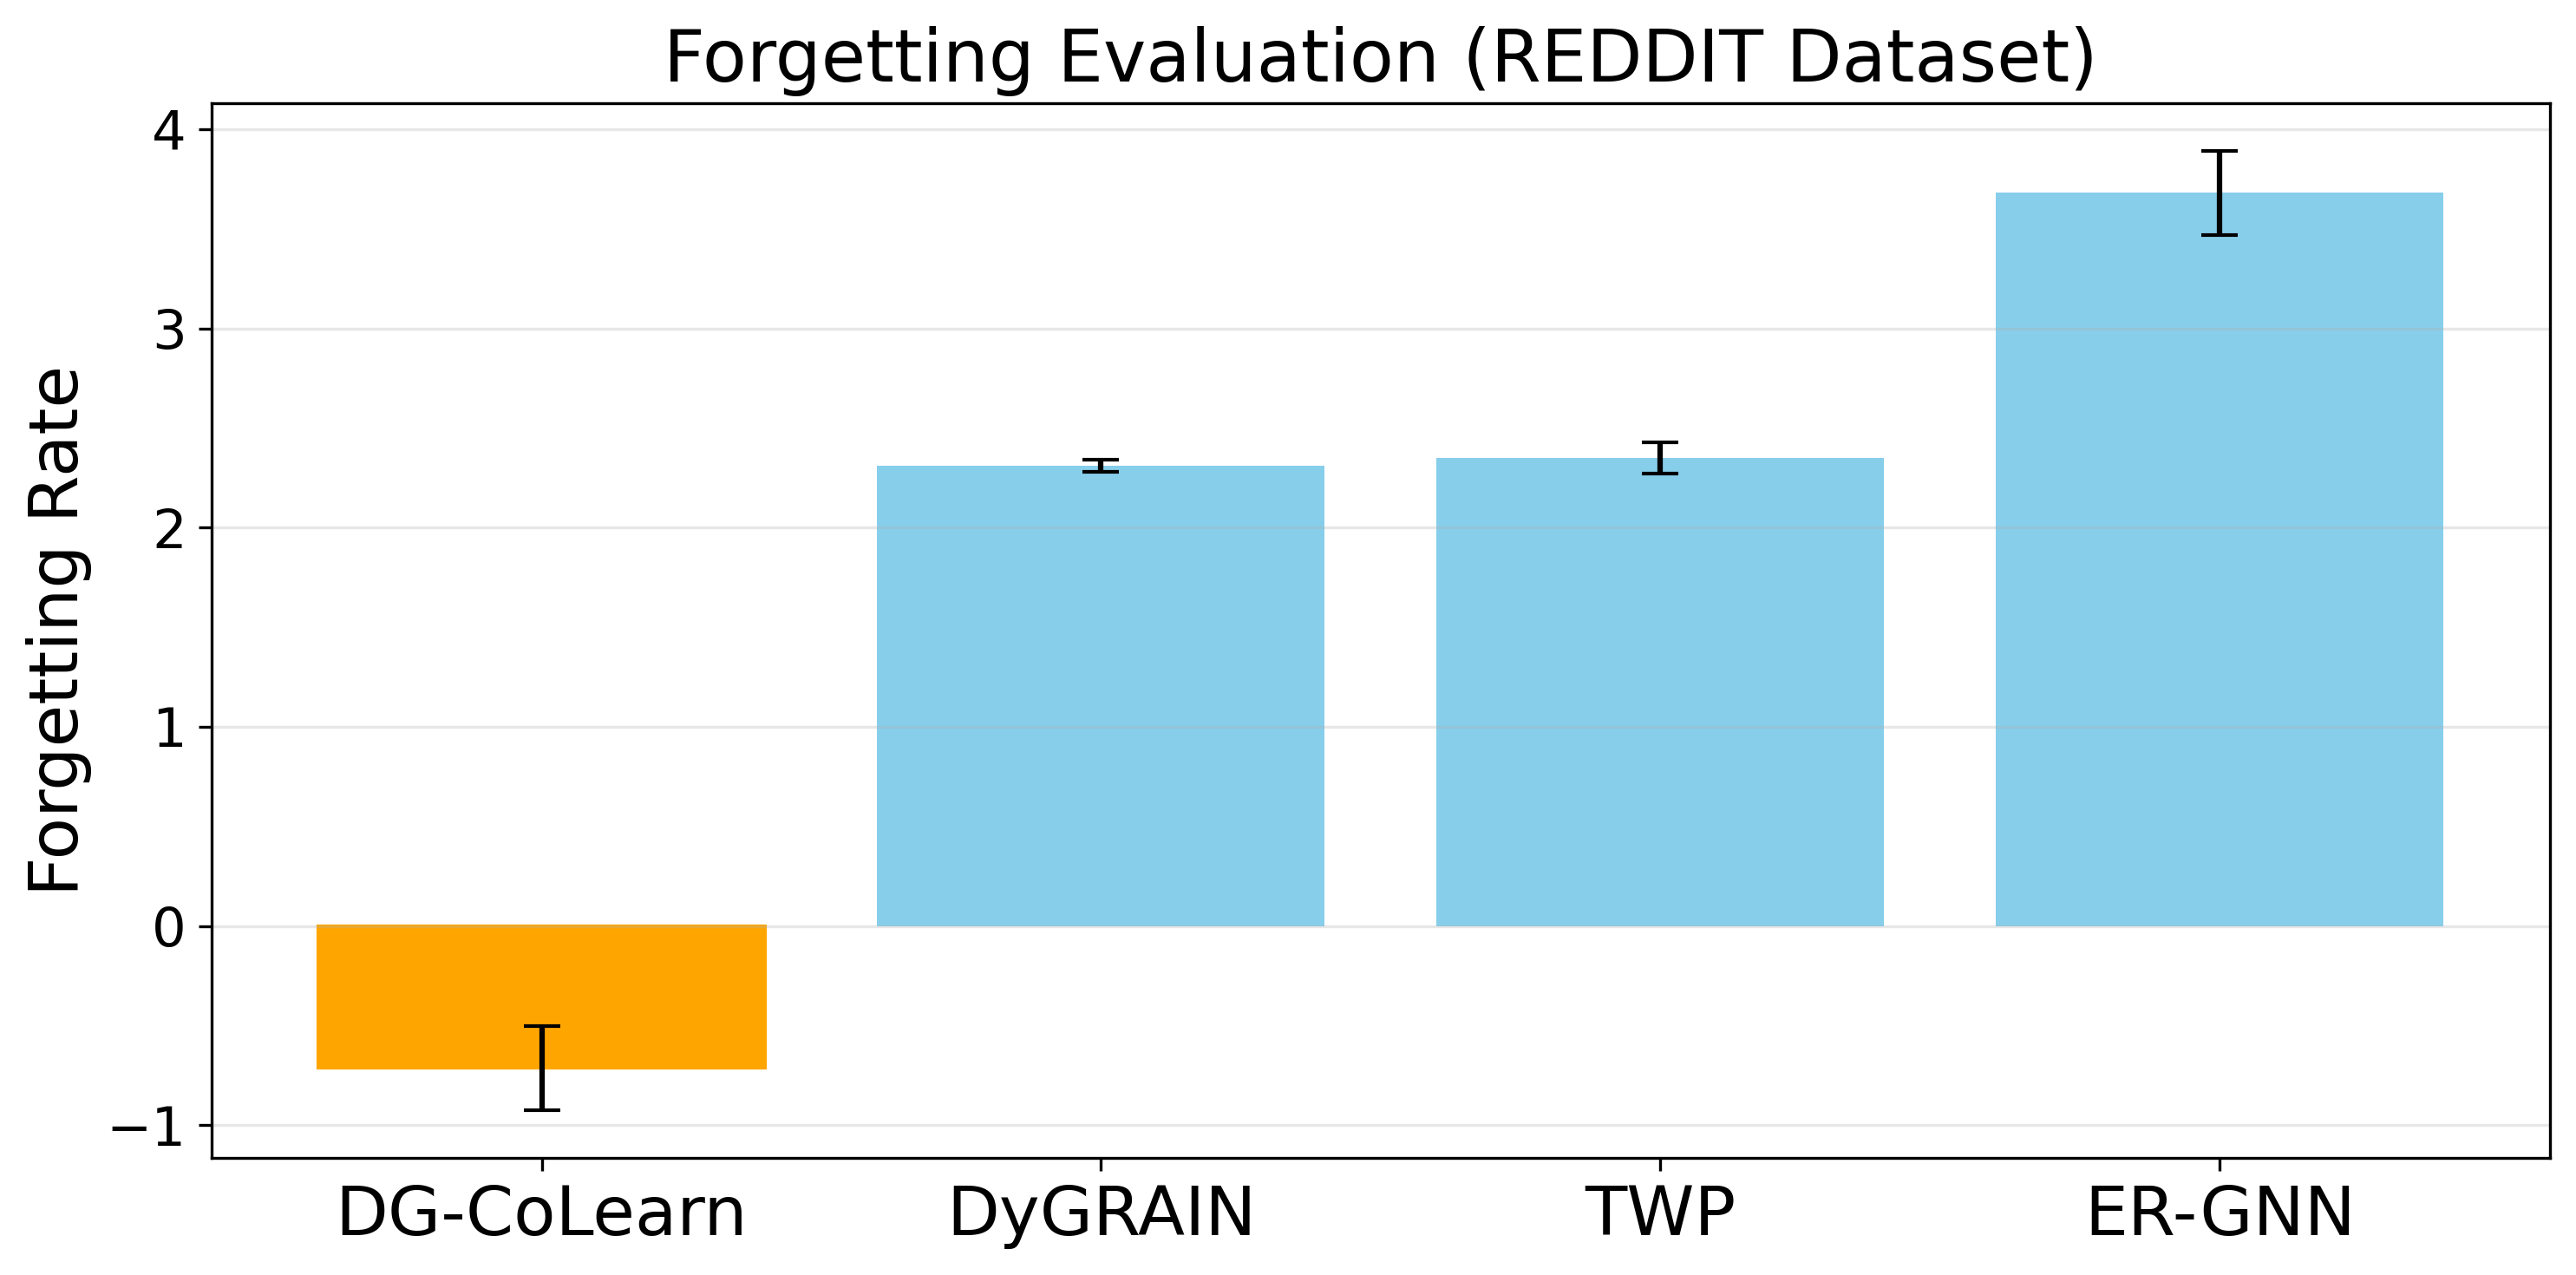

In [95]:
# Your result (mean and std of Reddit and Reddit2)
your_result = {
    "Method": ["DG-CoLearn"],
    "Forgetting": [-0.713],
    "Uncertainty (±)": [0.21]
}

# Baseline results (REDDIT only)
baselines = {
    "Method": ["ER-GNN", "TWP","DyGRAIN"],
    "Forgetting": [3.68, 2.35, 2.31],
    "Uncertainty (±)": [0.21, 0.08, 0.03]
}

# Combine data
df = pd.concat([pd.DataFrame(your_result), pd.DataFrame(baselines)])
print(df[["Method", "Forgetting", "Uncertainty (±)"]])

# Sort by forgetting for clarity
df_sorted = df.sort_values("Forgetting")

# Plot
plt.figure(figsize=(10, 5), dpi=300)
bars = plt.bar(
    df_sorted["Method"], df_sorted["Forgetting"],
    yerr=df_sorted["Uncertainty (±)"], capsize=5, color="skyblue"
)

# Highlight your method
bars[df_sorted["Method"].tolist().index("DG-CoLearn")].set_color("orange")

plt.ylabel("Forgetting Rate", fontsize=19)
plt.yticks(fontsize=15)
plt.title("Forgetting Evaluation (REDDIT Dataset)", fontsize=20)
plt.xticks(fontsize=19)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
# plt.show()

plt.savefig(
    'stats/fast_gpa/20250801/figures/forgetting.png',  # or .tiff
    dpi=300,          # Dots per inch (300+ for print)
)